<a href="https://colab.research.google.com/github/JaeHongLeee/Machine-Learning/blob/main/knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

이 완성된 워크시트(해당 출력 및 워크시트 외부의 지원 코드 포함)를 과제 제출과 함께 작성하여 제출하십시오. 자세한 내용은 코스 웹 사이트의 과제 페이지를 참조하십시오.


kNN 분류기는 두 단계로 구성됩니다.
*  훈련하는 동안 분류기는 훈련 데이터를 가져와 단순히 기억합니다.
*  테스트하는 동안 kNN은 모든 훈련 이미지와 비교하고 k개의 가장 유사한 훈련 예제의 레이블을 전송하여 모든 테스트 이미지를 분류합니다.
*  
k 값은 교차 검증됨

이 연습에서는 이러한 단계를 구현하고 기본 이미지 분류 파이프라인, 교차 검증을 이해하고 효율적인 벡터화된 코드 작성에 능숙해집니다.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

필요한 패키지들을 불러오고 plot을 그릴 때 기본 설정들을 해주었고, cifar-10 데이터셋에서 필요한 데이터들을 불러왔다.

In [3]:
# CIFAR-10 데이터 로드하기
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

#
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


class는 plane부터 truck 까지 10종류가 있고, 각 class당 7개의 example 사진들을 불러왔다.

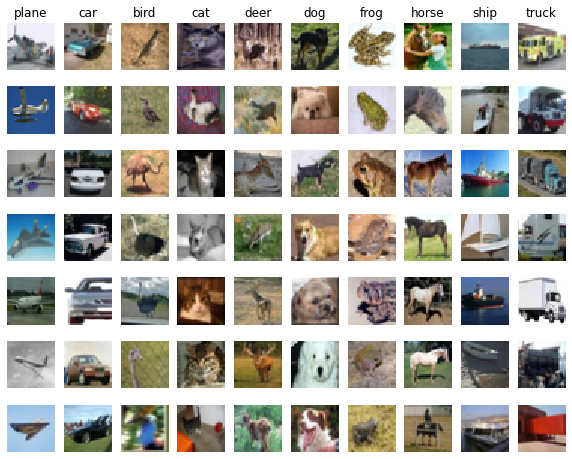

In [4]:

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [6]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

이제 kNN 분류기로 테스트 데이터를 분류하려고 합니다. 이 프로세스를 두 단계로 나눌 수 있음을 기억하십시오.

1.  먼저 모든 테스트 예제와 모든 기차 예제 사이의 거리를 계산해야 합니다.
2.  
이러한 거리가 주어지면 각 테스트 예제에 대해 k개의 가장 가까운 예제를 찾고 레이블에 투표하도록 합니다.

모든 훈련과 테스트 예제 사이의 거리 행렬을 계산하는 것으로 시작하겠습니다. 예를 들어, Ntr 훈련 예제와 Nte 테스트 예제가 있는 경우 이 단계에서는 각 요소 (i,j)가 i번째 테스트와 j번째 훈련 예제 사이의 거리인 Nte x Ntr 행렬이 생성되어야 합니다.

참고: 이 노트북에서 구현해야 하는 세 가지 거리 계산의 경우 numpy가 제공하는 np.linalg.norm() 함수를 사용할 수 없습니다.

먼저 cs231n/classifiers/k_nearest_neighbor.py를 열고 (테스트, 훈련) 예제의 모든 쌍에 대해 (매우 비효율적인) 이중 루프를 사용하고 한 번에 한 요소의 거리 행렬을 계산하는 함수 compute_distances_two_loops를 구현합니다.

In [12]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


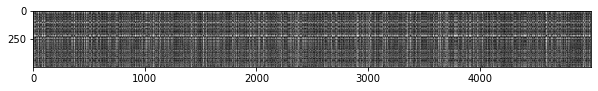

In [13]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1** 

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ 세로축은 test set, 가로축은 train set에 해당하며, 색이 밝을수록 L2 distance가 큽니다. 가로에 밝은 선이 의미하는건 어떤 test data가 모든 train data와 L2 거리가 멀다는 의미이고, 세로 선은 반대로 어떤 train data가 모든 test data와 거리가 멀다는 것이다.



일부 행이나 열이 더 밝게 보이는 거리 행렬의 구조화된 패턴에 주목하십시오. (기본 색 구성표에서 검은색은 낮은 거리를 나타내고 흰색은 높은 거리를 나타냅니다.)
*  데이터에서 뚜렷하게 밝은 행의 원인은 무엇입니까?
*  열의 원인은 무엇입니까?

In [17]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

약 27%의 정확도를 기대할 수 있습니다. 이제 더 큰 k, 예를 들어 k = 5를 시도해 보겠습니다.

In [16]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

k = 1일 때보다 약간 더 나은 성능을 기대할 수 있습니다.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, 

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

$\color{blue}{\textit Your Answer:}$ 1번, 3번


$\color{blue}{\textit Your Explanation:}$


L1 거리와 같은 다른 거리 메트릭을 사용할 수도 있습니다. 일부 이미지 $I_k$의 위치 $(i,j)$에 있는 픽셀 값 $p_{ij}^{(k)}$의 경우,

모든 이미지의 모든 픽셀에 대한 평균 μ는
$$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$

그리고 모든 이미지에 걸친 픽셀 단위 평균 $\mu_{ij}$는
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$

일반 표준 편차 $\sigma$ 및 픽셀 단위 표준 편차 $\sigma_{ij}$도 유사하게 정의됩니다.

다음 중 L1 거리를 사용하는 Nearest Neighbor 분류기의 성능을 변경하지 않는 전처리 단계는 무엇입니까? 해당되는 모든 것들을 고르세요.
1. 평균 $\mu$ 빼기 ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. 
픽셀당 평균을 빼면 $\mu_{ij}$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.) 
3. 평균 $\mu$를 빼고 표준 편차 $\sigma$로 나눕니다.
4. 픽셀 단위 평균 $\mu_{ij}$ 빼기 및 픽셀 단위 나누기
5. 데이터의 좌표축을 회전합니다.


In [ ]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

Two loop version took 0.077273 seconds
One loop version took 0.003549 seconds
No loop version took 0.003310 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.


### 교차 검증

k-Nearest Neighbor 분류기를 구현했지만 k = 5 값을 임의로 설정했습니다. 이제 교차 검증을 통해 이 하이퍼파라미터의 최상의 값을 결정할 것입니다.

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = np.array(np.split(X_train, num_folds))
y_train_folds = np.array(np.split(y_train, num_folds))
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


for i in k_choices:
    k_to_accuracies[i] = []
    for j in range(num_folds):
        pos = list(range(num_folds))
        pos.remove(j)
        X = np.vstack(X_train_folds[pos])
        y = np.hstack(y_train_folds[pos])
        classifier = KNearestNeighbor()
        classifier.train(X, y)
        dists = classifier.compute_distances_no_loops(X_train_folds[j])
        y_test_pred = classifier.predict_labels(dists, k=i)
        num_correct = np.sum(y_test_pred == y_train_folds[j])
        accuracy = float(num_correct) / len(X_train_folds[j])
        k_to_accuracies[i].append(accuracy)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.102000
k = 1, accuracy = 0.100000
k = 1, accuracy = 0.097000
k = 1, accuracy = 0.097000
k = 1, accuracy = 0.109000
k = 3, accuracy = 0.102000
k = 3, accuracy = 0.100000
k = 3, accuracy = 0.097000
k = 3, accuracy = 0.097000
k = 3, accuracy = 0.109000
k = 5, accuracy = 0.102000
k = 5, accuracy = 0.100000
k = 5, accuracy = 0.097000
k = 5, accuracy = 0.097000
k = 5, accuracy = 0.109000
k = 8, accuracy = 0.102000
k = 8, accuracy = 0.100000
k = 8, accuracy = 0.097000
k = 8, accuracy = 0.097000
k = 8, accuracy = 0.109000
k = 10, accuracy = 0.102000
k = 10, accuracy = 0.100000
k = 10, accuracy = 0.097000
k = 10, accuracy = 0.097000
k = 10, accuracy = 0.109000
k = 12, accuracy = 0.102000
k = 12, accuracy = 0.100000
k = 12, accuracy = 0.097000
k = 12, accuracy = 0.097000
k = 12, accuracy = 0.109000
k = 15, accuracy = 0.102000
k = 15, accuracy = 0.100000
k = 15, accuracy = 0.097000
k = 15, accuracy = 0.097000
k = 15, accuracy = 0.109000
k = 20, accuracy = 0.102000
k = 20, accu

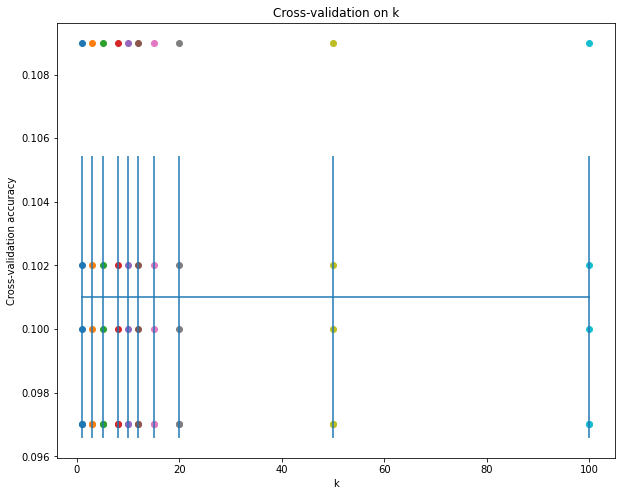

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 57 / 500 correct => accuracy: 0.114000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



$k$-최근접 이웃($k$-NN)에 대한 다음 설명 중 분류 설정 및 모든 $k$에 대해 참인 것은 무엇입니까? 해당되는 모든 것들을 고르세요.

1. k-NN 분류기의 결정 경계는 선형입니다.
2. 1-NN의 훈련 오류는 항상 5-NN의 훈련 오류보다 낮거나 같습니다
3. 1-NN의 테스트 오류는 항상 5-NN의 테스트 오류보다 낮습니다.
4. 
k-NN 분류기로 테스트 예제를 분류하는 데 필요한 시간은 훈련 세트의 크기에 따라 늘어납니다.
5. 
위의 어느 것도 아닙니다.